<a href="https://colab.research.google.com/github/1337DS/Covid-Chatbot/blob/main/Testing_RKI_API.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Testing the Robert Koch Institute COVID-19 API

The documentation for the API can be found [here](https://api.corona-zahlen.org/docs/endpoints/germany.html#germany-2)

## 1. Create a class for basic HTTP functionality

In [ ]:
# load modules to send and receive HTTP messages
import requests as req
import json
from datetime import datetime as dt

# modules for visualization and storing / modifying data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
class Endpoint_Requester():
  def __init__(self, endpoint):
    self.base_url = "https://api.corona-zahlen.org"
    self.endpoint = endpoint # this must be definied by when the class is instanciated
    #self.json_cache = {} # requested data will be stored here for caching 

  def get_json(self, url_param=None, payload=None):
    """
    Send a HTTP GET request to the API Endpoint that is provided 
    when an object is instanciated and processes the JSON response.
    If there is an error or the HTTP status code is not OK (200) 
    the return value is None.

    Parameters:
    ---
    :url_param (str): 
    is appended to the end of the URL. It can be used to specify 
    things like amount of days or pages. 
    E.g. "URL/germany/history/cases/:days" 

    :payload (dict):
    Dict that is treated as a URL encoded JSON string.
    E.g. {"key1": "val1", "key2": "val2"} 
    will be encoded as
    URL/?key1=val1&key2=val2
    """
    # use either an empty string or use a slash followed by the parameters
    param_str = "" if url_param is None else f"/{url_param}"
    
    # send the request and convert it to json
    res = req.get(
        f"{self.base_url}{self.endpoint}{param_str}",
        params=payload
        )
    
    status = res.status_code
    if status == 200: # if the request status code is successfull
      try:
        return res.json()
      except:
        print("Could not convert the request to JSON.")
        return None 
    else:
      print(f"The request wasn't successfull. The HTTP response status code was {status}")
      return None

  def to_df(self, data, time_att="date"):
    """
    Returns a pd.DataFrame based on the data input.

    Parameters:
    ---
    :data (list): 
    Is expected to be a list of dicts.
    
    :time_att (str | None): 
    Column name that is converted to datetime and 
    used as index of the dataframe.
    If it is None no index is set.
    
    returns:
    ---
    pd.DataFrame
    """
    df = pd.DataFrame(data)

    if time_att is not None:
      # this conversion could lead to an error if the request doesn't
      # have the literals ".000z" in the end
      df[time_att] = df[time_att].apply(lambda date: dt.strptime(date, "%Y-%m-%dT%H:%M:%S.000z"))
      df = df.set_index(time_att)

    return df




## 2. Germany Endpoint

In [ ]:
class Endpoint_Germany(Endpoint_Requester):
  def __init__(self):
    super().__init__("/germany")
    self.valid_history_endpoints = [
      "incidence", 
      "deaths",
      "recovered",
      "frozen-incidence",
      "hospitalization"
    ]

    self.valid_hospitalization_endpoints = [
      "incidence7Days",
      "cases7Days"
    ]

    self.valid_demographic_endpoints = [
      "cases",
      "casesPer100k"
      "deaths",
      "deathsPer100k"
    ]

  def valid_list_items(self, l1, l2):
    """
    Checks if all items from l1 are also inside l2.
    """
    s1 = set(l1)
    s2 = set(l2)

    # check if the list items are unique
    if not (len(l1) == len(s1) and len(l2) == len(s2)):
      print(f"The items in either list is not unique l1 = {l1} l2 = {l2}")
      return False

    # check if the intersection between the lists is identical to the length of the whole list
    if len(l1.intersection(l2)) == len(l1):
      return True
    
    # if the check didn't give a result, then the items are not valid
    return False

  def get_history(self, metric, hospitalization=None, days=None, as_df=True):
    """
    Returns the historic data of a Covid-19 metric in germany.
    An example what metric means in this context can be found below.
    
    Parameters:
    ---
    :metric (str):
    The name of a /germany/history/<metric> endpoint.
    Possible metric values are listed in the variable
    self.valid_history_endpoints

    :hospitalization (str):
    This parameter is the name of the hospitalization sub-metric.
    Only use this if you use "hospitalization" for the 'metric' parameter.
    If you don't provide a value, while using metric='hospitalization' 
    you will get all sub-metrics.
    Possible values are listed in the variable
    self.valid_hospitalization_endpoints:
    - "incidence7Days",
    - "cases7Days"


    :days (int): 
    number of days that are requested from now into the past. 
    Without providing a value all dates are requested.
    
    :as_df (bool): 
    This function returns a pd.DataFrame if True. 
    Otherwise it returns a dict.

    Returns:
    ---
    (data, last_updated) or (None, None)
    
    :data (pd.DataFrame|dict): The received data value depends on parameter "as_df"
    :last_updated (datetime): Date of the last update of that data
    :None: in case of an error
    """
    # The returned json is structured like so:
    # data: [{"cases": (integer), "date": (datetime)}, ...],
    # meta: {"lastUpdate": (datetime)}
    if not metric in self.valid_history_endpoints:
      print(f"You must provide a valid endpoint. \
      Available endpoints are: {self.valid_history_endpoints}")
      return None, None

    if isinstance(days, int):
      days_param = f"/{days}"
    else:
      days_param = ""

    # send json to get covid cases and use days if it was an integer
    json = self.get_json(url_param=f"history/{metric}{days_param}")

    try:
      last_updated = json["meta"]["lastUpdate"]
    except:
      print("Corrupted JSON couldn't read last update date")
      return None, None

    # if no hospitalization sub-metric is needed, just use the json.data list
    if hospitalization is None:
      json_data = json["data"]
    # extract the correct sub-metric from "hospitalization" metric
    elif hospitalization in self.valid_hospitalization_endpoints:
      # only extract the value of 'hospitalization' and the date
      # the variable json is a list of dicts.
      # each dict hast a date and the sub-metrics listed in self.valid_hospitalization_endpoints
      json_data = [
        {"date": j["date"], hospitalization: j[hospitalization]} 
        for j in json["data"]
        ]
    else:
      print(f"You didn't specify a valid option for the parameter 'hospitalization'. \
      Valid options are: {self.valid_hospitalization_endpoints}")
      return None, None

    if as_df:
      return self.to_df(json_data), last_updated
    else:
      return json_data, last_updated
    
  def add_sex_to_metric(self, metric):
    """
    Returns the correct metric label for the get_demographic() method.
    """
    # add Female and Male to the metric names
    if  metric == "deathsPer100k":
      return ["deathsMalePer100k", "deathsFemalePer100k"]
    elif metric == "casesPer100k":
      return ["casesMalePer100k", "casesFemalePer100k"]
    else:
      return [metric + "Male", metric + "Female"]


  def get_demographic(self, metric, split_sex=True, as_df=True):
    """
    Returns the current data of one or multiple Covid-19 metrics 
    in germany grouped by age groups and gender.
    An example what metric means in this context can be found below.
    It uses the endpoint URL/germany/age-groups.
    
    Parameters:
    ---
    :metric (str | list):
    The name or list of names of the metrics.
    Possible metric values are listed in the variable
    self.valid_demographic_endpoints.
    
    :split_sex (bool):
    If True will group each metric in two different columns for male and female.
    If False male and female are combined into one value.

    :as_df (bool): 
    This function returns a pd.DataFrame if True. 
    Otherwise it returns a dict.

    Returns:
    ---
    (data, last_updated) or (None, None)
    
    :data (pd.DataFrame|dict): The received data value depends on parameter "as_df"
    :last_updated (datetime): Date of the last update of that data
    :None: in case of an error
    """
    # send json to get demographics data, no further URL parameters needed
    json = self.get_json(url_param="age-groups")
    df = self.to_df(json["data"], time_att=None)

    try:
      last_updated = json["meta"]["lastUpdate"]
    except:
      print("Corrupted JSON couldn't read last update date")
      return None, None
    
    if isinstance(metric, str) and metric in self.valid_demographic_endpoints:
      metrics = self.add_sex_to_metric(metric)
      df = df.loc[metrics]

    # check if all items from metric list are also in self.valid_demographic_endpoints
    elif isinstance(metric, list) and self.valid_list_items(metric, self.valid_demographic_endpoints):
      metrics = []
      for m in metric:
        # add the items from the metrics with sex to the total list of metrics
        metrics.extend(self.add_sex_to_metric(m))
      df = df.loc[metrics]

    # if metric is invalid 
    else:
      return None, None
    
    return df, last_updated
      
      

In [ ]:
ger = Endpoint_Germany()
df, updated = ger.get_history("deaths", as_df=True)
df2, updated = ger.get_history("incidence")

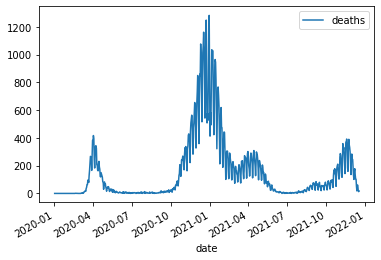

In [ ]:
df.plot()

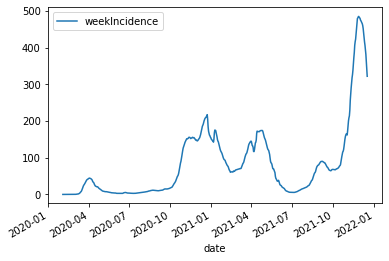

In [ ]:
df2.plot()

In [ ]:
ger.get_json(url_param="age-groups")

{'data': {'A00-A04': {'casesFemale': 92740,
   'casesFemalePer100k': 4797.6,
   'casesMale': 99549,
   'casesMalePer100k': 4889.2,
   'deathsFemale': 11,
   'deathsFemalePer100k': 0.6,
   'deathsMale': 5,
   'deathsMalePer100k': 0.2,
   'hospitalization': {'cases7Days': 97,
    'date': '2021-12-18T00:00:00.000Z',
    'incidence7Days': 2.44}},
  'A05-A14': {'casesFemale': 402954,
   'casesFemalePer100k': 11044.7,
   'casesMale': 437875,
   'casesMalePer100k': 11343.1,
   'deathsFemale': 9,
   'deathsFemalePer100k': 0.2,
   'deathsMale': 5,
   'deathsMalePer100k': 0.1,
   'hospitalization': {'cases7Days': 98,
    'date': '2021-12-18T00:00:00.000Z',
    'incidence7Days': 1.31}},
  'A15-A34': {'casesFemale': 967718,
   'casesFemalePer100k': 10627.4,
   'casesMale': 980896,
   'casesMalePer100k': 9993.4,
   'deathsFemale': 110,
   'deathsFemalePer100k': 1.2,
   'deathsMale': 176,
   'deathsMalePer100k': 1.8,
   'hospitalization': {'cases7Days': 393,
    'date': '2021-12-18T00:00:00.000Z',
 

In [ ]:
ger = Endpoint_Germany()
ger.get_demographic("cases")

KeyError: ignored

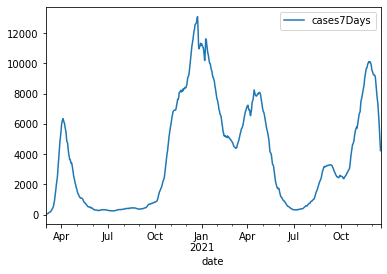

In [ ]:
df.plot()

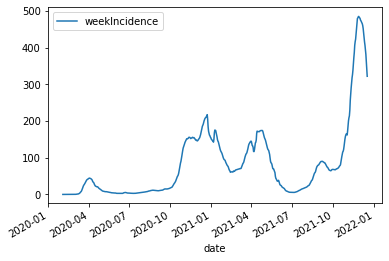

In [ ]:
df2.plot()

In [ ]:
df.index

DatetimeIndex(['2020-01-02', '2020-01-23', '2020-01-28', '2020-01-29',
               '2020-01-31', '2020-02-01', '2020-02-03', '2020-02-04',
               '2020-02-05', '2020-02-06',
               ...
               '2021-12-07', '2021-12-08', '2021-12-09', '2021-12-10',
               '2021-12-11', '2021-12-12', '2021-12-13', '2021-12-14',
               '2021-12-15', '2021-12-16'],
              dtype='datetime64[ns]', name='date', length=677, freq=None)

In [ ]:
r = req.get(
        f"https://api.corona-zahlen.org/germany/age-groups",
        params=None
        ).json()

date = r["meta"]["lastUpdate"]

df = pd.DataFrame(r["data"])

In [ ]:
df.loc[['casesMale', "casesFemale"]]

,A00-A04,A05-A14,A15-A34,A35-A59,A60-A79,A80+
casesMale,99549,437875,980896,1207003,429802,136109
casesFemale,92740,402954,967718,1276219,435795,252222


Experimenting with PNG responses

In [ ]:
from PIL import Image
from io import BytesIO

r = req.get("https://api.corona-zahlen.org/map/districts-legend")
img = Image.open(BytesIO(r.content))

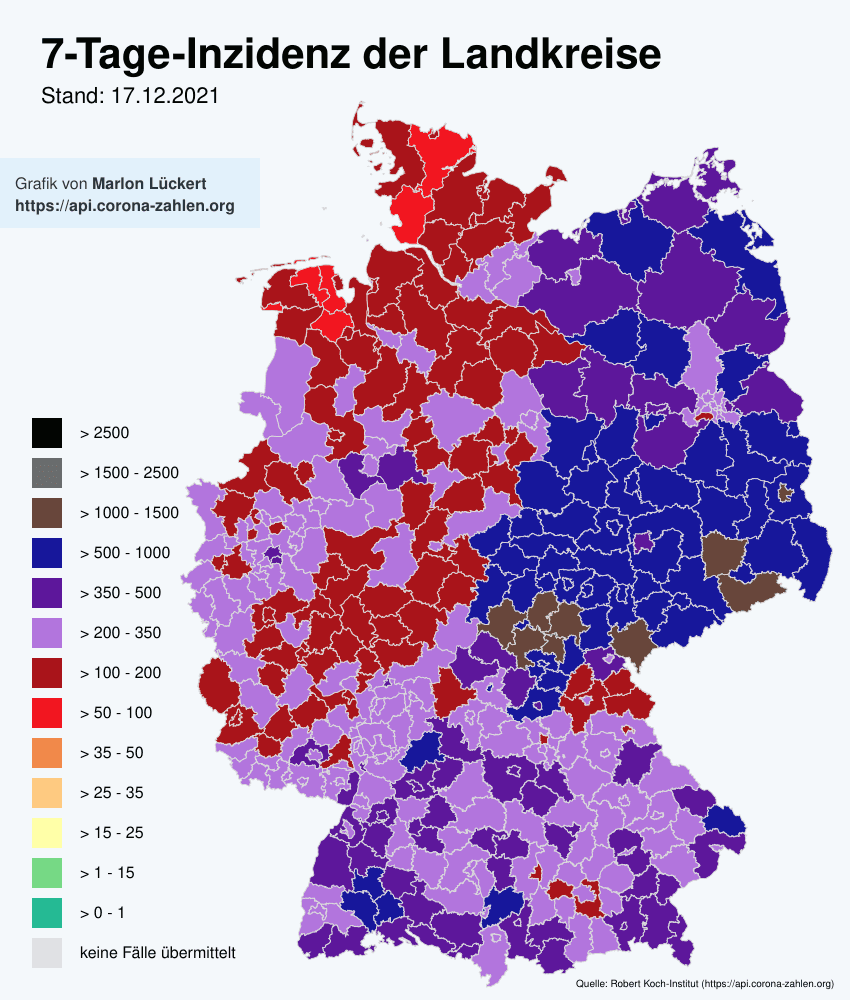

In [ ]:
display(img)